In [21]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import scipy.signal as signal
from math import log10
from opensignalsreader import OpenSignalsReader
import statistics

import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from scipy import interpolate
from scipy.stats import zscore


**SE OBTIENE EL DATASET**




In [4]:
fs= 1000;
# Ruta al archivo de texto
archivo = 'Alvaro_reposo.txt'

# Leer el archivo omitiendo las líneas de comentarios y el encabezado
data = pd.read_csv(archivo, delimiter='\t', comment='#', header=None)

# Extraer la sexta columna, que corresponde al índice 5 (los índices empiezan en 0)
amplitud = data.iloc[100:28199, 5]
# Convertir valores crudos a milivoltios
voltaje_por_unidad = 3.3 / 1023
new_data = amplitud * voltaje_por_unidad * 1000  # Conversión a mV

# Crear una lista para el eje X, que va desde 1 hasta el número de elementos en valores_y
n = np.arange(1, len(new_data) + 1)
ts=n/fs;

print(new_data)


100      1522.580645
101      1503.225806
102      1493.548387
103      1490.322581
104      1500.000000
            ...     
28194    1619.354839
28195    1596.774194
28196    1587.096774
28197    1590.322581
28198    1600.000000
Name: 5, Length: 28099, dtype: float64


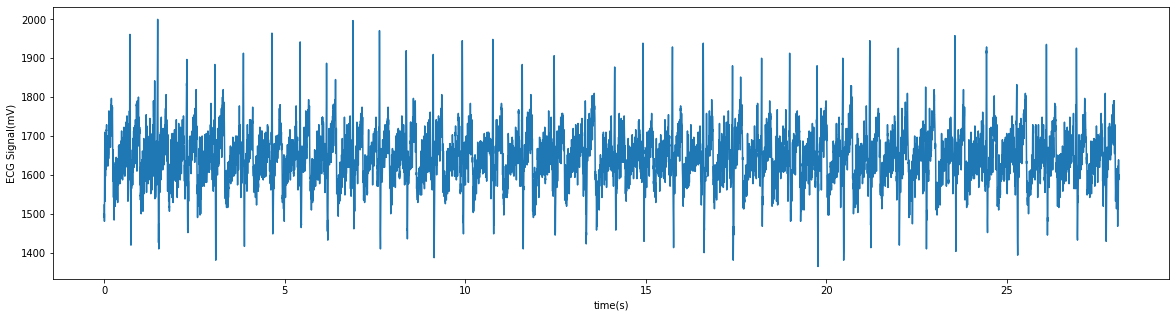

In [5]:
# A numpy
plt.figure(figsize=(20,5))
plt.plot(ts, new_data)
plt.ylabel('ECG Signal(mV)')
plt.xlabel('time(s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

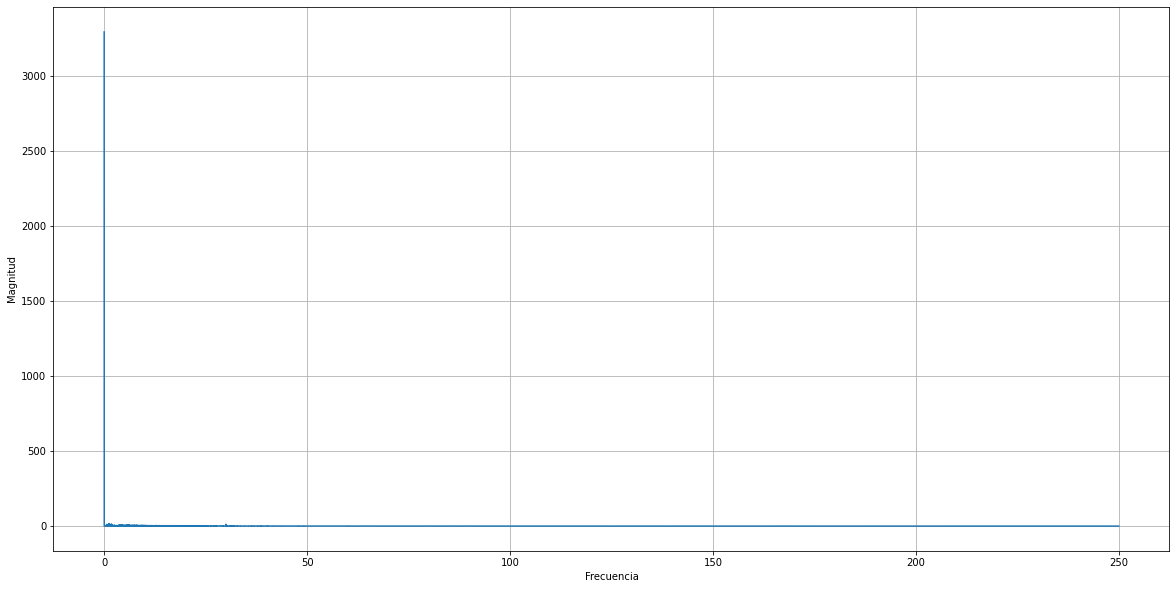

In [6]:
# Analizar el Fourier
voltaje= new_data.to_numpy()
ecg_senal = voltaje
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(ecg_senal)
yf = fft(ecg_senal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

**FILTRADO DE PASA BAJA**

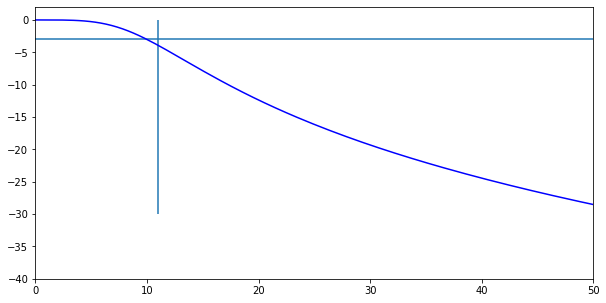

In [7]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks, lfilter
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 10, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

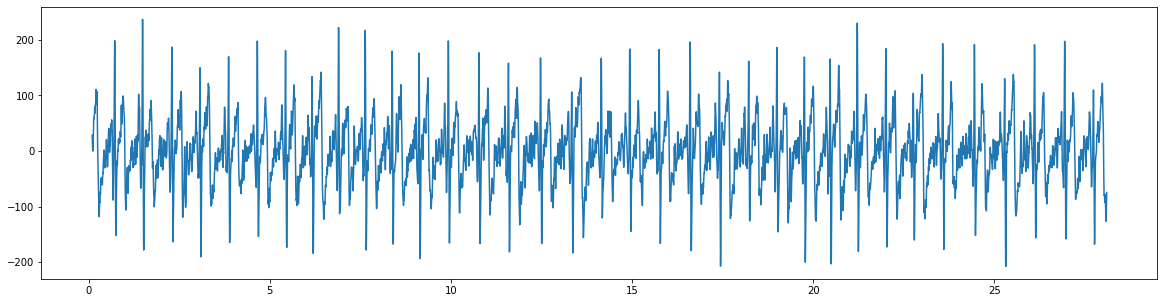

In [22]:
fpb_signal = lfilter(b, a, ecg_senal)
fpb_signal = fpb_signal[100:len(fpb_signal)]
fpb_signal2=fpb_signal-statistics.mean(fpb_signal)
ts2=ts[100:len(ts)]
plt.figure(figsize=(20,5))
plt.plot(ts2,fpb_signal2)
plt.show()

## RR peak detection

In [23]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# use sine to approximate QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
ecg_transformed = np.correlate(fpb_signal2, peak_filter, mode="same")

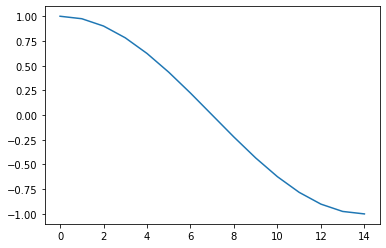

In [24]:
# template matching technique using sine filter

plt.plot(peak_filter)

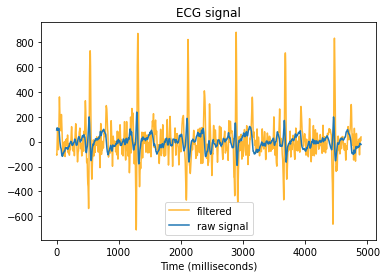

In [25]:
plt.title('ECG signal')
plt.plot(ecg_transformed[100:5000], alpha = 0.8, c='orange')
plt.plot(fpb_signal2[100:5000], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

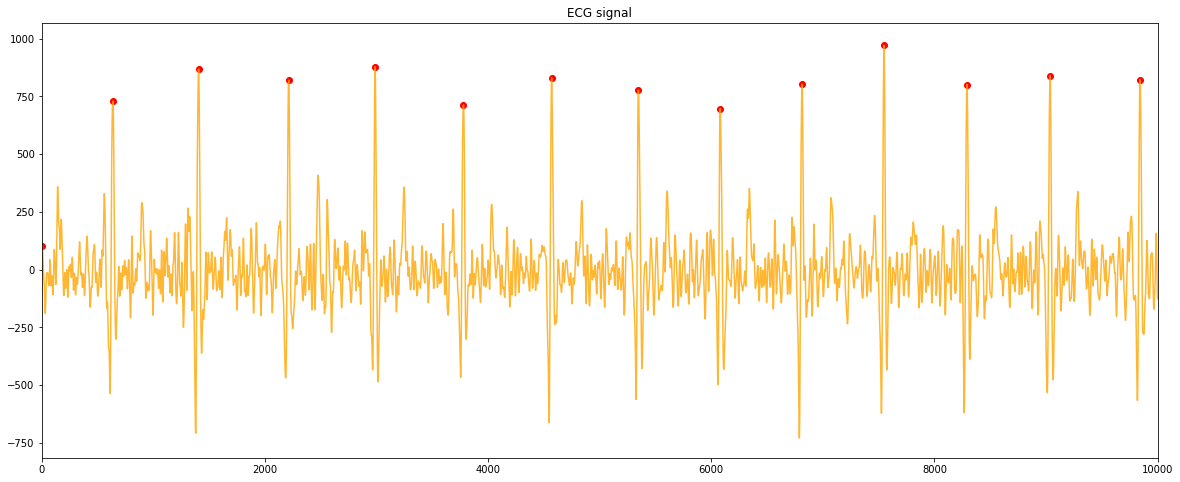

In [30]:
rr_peaks, _ = find_peaks(ecg_transformed, distance=1000*(30/60))
plt.figure(figsize=(20,8))
plt.plot(ecg_transformed, alpha = 0.8,c='orange')
plt.scatter(rr_peaks, ecg_transformed[rr_peaks], color='red')
plt.xlim(0,10000)
plt.title("ECG signal")
plt.show()

In [34]:
# the R-R intervals
rr_ecg = np.diff(rr_peaks)
# a look at the timedomain metrics for the sample
timedomain(rr_ecg)

{'Mean RR (ms)': 789.7714285714286,
 'STD RR/SDNN (ms)': 49.74453923470866,
 "Mean HR (Kubios' style) (beats/min)": 75.9713479487736,
 'Mean HR (beats/min)': 76.29035386948878,
 'STD HR (beats/min)': 5.0982212478168245,
 'Min HR (beats/min)': 67.41573033707866,
 'Max HR (beats/min)': 94.9367088607595,
 'RMSSD (ms)': 42.59280524717208,
 'NNxx': 24,
 'pNNxx (%)': 68.57142857142857}

In [33]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    # HRV metrics
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 20)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 20)*1) / len(rr)
    return results
